# Lab 6: Mixture Models + Model order selection

The goal of this lab session is to study mixture models. In the first part you will code the EM algorithm to estimate the parameters of a GMM given the number of mixed distributions and in the second part you will try different model order selection methods. You will send only one notebook for both parts.

You have to send the filled notebook named **"L4_6_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2020@gmail.com before November 28 at 23:59 and put **"AML-L4-6"** in the subject. 

We begin with the standard imports:

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
from scipy.stats import pearsonr

We will have two toy datasets to try the different methods:

# GMM

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. After estimation of those parameters we get an estimation of the distribution of our data. For the clustering task, one can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians. 

# First part

Fill in the following class to implement a multivariate GMM:

In [41]:
class my_GMM():
    
    def __init__(self, k, initialization):
        '''
        Parameters:
        k: integer
            number of components
        
        Attributes:
        
        alpha_: np.array
            proportion of components
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        labels_: (n, ) np.array
            labels for data points
        '''
        self.k_ = k
        self.alpha_ = None
        self.mu_ = None
        self.Sigma_ = None
        self.cond_prob_ = None
        self.labels_ = None
        self.initialization_ = initialization
        
    def compute_condition_prob_matrix(self, X, alpha, mu, Sigma):
        '''Compute the conditional probability matrix 
        shape: (n, K)
        '''
        #Compute Probability matrix
        n, p = np.shape(X)
        proba_matrix = np.zeros((n,self.k_))

        for i in range(self.k_):
            proba_matrix[:,i] = multivariate_normal.pdf(X, mu[i], Sigma[:,:,i])
        proba_matrix = proba_matrix*alpha
        proba_matrix /= np.sum(proba_matrix, axis= 1, keepdims=True)
        #print(proba_matrix)
        return proba_matrix

    def fit(self, X):
        """ Find the parameters
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """
        
        n, p = np.shape(X)
        self.cond_prob_ = np.zeros((n,self.k_))
        index_max = 0
        self.labels_ = np.zeros((n,1))
        iteration = 0
        
        #Initialisation
        if self.initialization_ == "kmeans":
            model = KMeans(self.k_)
            model.fit(X)
            self.mu_ = model.cluster_centers_
            self.alpha_ = np.unique(model.labels_, return_counts=True)[1]/n
            self.Sigma_ = np.zeros((p,p,self.k_))
            
            #initialize sigma using the usual estimator for the covariance matrix
            for i in range(self.k_):
                X_mu = X[model.labels_ == i] - self.mu_[i]
                number_i = np.shape(X_mu)[0]
                self.Sigma_[:,:,i] = np.dot(X_mu.T, X_mu)/number_i
            
                
        elif self.initialization_ == "random":
            self.mu_ = np.random.rand(self.k_, p)
            self.alpha_ = np.ones(self.k_)/self.k_
            self.Sigma_ = np.repeat(np.eye(p)[:,:,None],self.k_, axis=2) 

        else:
            return "Wrong initialization, please initialize with kmeans or random"
        
        #Implement the EM algorithm
        eps = 1e-4
        norm_dif = 1
        converge = False
        
        #while norm_dif > eps:
        while not(converge):
            
            #keeping the values from the previous iteration for convergence
            old_mu = self.mu_
            old_sigma = self.Sigma_
            old_prop = self.alpha_
            
            #compute the condition probability matrix
            self.cond_prob_ = self.compute_condition_prob_matrix(X, self.alpha_, self.mu_, self.Sigma_)
            
            #compute the new parameters
            self.alpha_ = np.mean(self.cond_prob_, axis=0)
            self.mu_ = np.dot(self.cond_prob_.T, X)/(self.alpha_[:, None]*n)
            self.Sigma_ = np.zeros((p,p,self.k_))
            for i in range(self.k_):
                X_mu_new = X - self.mu_[i]
                self.Sigma_[:,:,i] = np.dot(X_mu_new.T, (self.cond_prob_[:,[i]]*X_mu_new))/(self.alpha_[i])
                #sigma_t[:,:,i] = np.dot((X - mu_t[i]).T, (cond_prob[:,[i]]*(X - mu_t[i])))/prob_k_t[i]
            self.Sigma_ /= n
                
            #check for convergence
            sigma_dif = np.isclose(self.Sigma_, old_sigma, rtol= 1e-4, atol=0).all()
            mu_dif = np.isclose(self.mu_, old_mu, rtol= 1e-4, atol=0).all()
            prop_dif = np.isclose(self.alpha_, old_prop, rtol= 1e-4, atol=0).all()
            converge = mu_dif*sigma_dif*prop_dif
            iteration += 1
        print('The number of iterations of the EM algorithm for ' + str(self.k_) +' clusters is: '+ str(iteration))
            
        
        # Update_labels_
        self.labels_ = np.argmax(self.compute_condition_prob_matrix(X, self.alpha_, self.mu_, self.Sigma_), axis=1)

        # Return self
        return self

        
    def predict(self, X):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assigment  
        """
        return np.argmax(self.compute_condition_prob_matrix(X, self.alpha_, self.mu_, self.Sigma_), axis=1)
    
    def compute_proba(self, X):
        """ Compute probability vector for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        proba: (n, k) np.array        
        """
        probabilities = self.compute_condition_prob_matrix(X, self.mu_, self.Sigma_, self.alpha_)
        return probabilities

Generate your own mixture of Gaussian distributions to test the model, choose parameters so that GMM performs better than K-Means on it. Use `np.random.multivariate_normal`. 

Plot data with colors representing predicted labels and shapes representing real labels.

### Simulations for testing the EM Algorithm

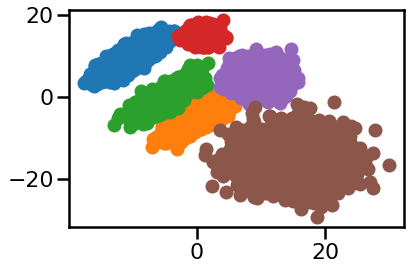

In [11]:
mu = np.array([[-10,10],[0,-5],[-5,0],[1,15],[10,5],[15,-15]])
sigma = np.zeros((2,2,6))
std_0 = np.array([[1,2],[2,1]])
std_1 = np.array([[1,2],[2,1]])
std_2 = np.array([[1,2],[2,1]])
std_3 = np.eye(2)
std_4 = 2*np.eye(2)
std_5 = 4*np.eye(2)
var_0, var_1, var_2, var_3, var_4, var_5 = std_0.T@std_0, std_1.T@std_1, std_2.T@std_2, std_3.T@std_3, std_4.T@std_4, std_5.T@std_5
sigma[:,:,0], sigma[:,:,1], sigma[:,:,2], sigma[:,:,3], sigma[:,:,4], sigma[:,:,5] = var_0, var_1, var_2, var_3, var_4, var_5


X_1 = np.random.multivariate_normal(mu[0], sigma[:,:,0], 2000)
X_2 = np.random.multivariate_normal(mu[1], sigma[:,:,1], 2000)
X_3 = np.random.multivariate_normal(mu[2], sigma[:,:,2], 2000)
X_4 = np.random.multivariate_normal(mu[3], sigma[:,:,3], 2000)
X_5 = np.random.multivariate_normal(mu[4], sigma[:,:,4], 2000)
X_6 = np.random.multivariate_normal(mu[5], sigma[:,:,5], 2000)

Y = np.vstack((X_1, X_2, X_3, X_4, X_5, X_6))
x, y = Y[:,0], Y[:,1]

plt.scatter(X_1[:,0], X_1[:,1])
plt.scatter(X_2[:,0], X_2[:,1])
plt.scatter(X_3[:,0], X_3[:,1])
plt.scatter(X_4[:,0], X_4[:,1])
plt.scatter(X_5[:,0], X_5[:,1])
plt.scatter(X_6[:,0], X_6[:,1])
plt.show()

### Testing for the kmeans initialization

The number of iterations of the EM algorithm for 6 clusters is: 8


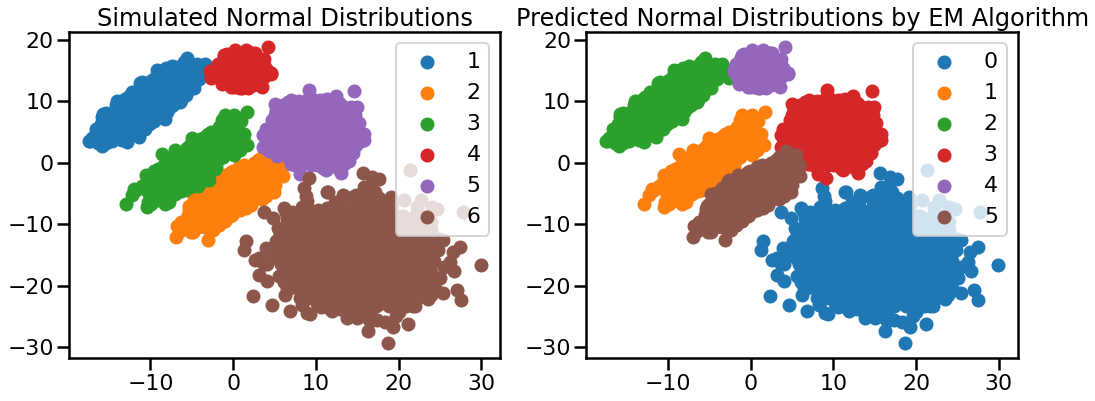

In [12]:
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal

GMM = my_GMM(k=6, initialization = "kmeans")
GMM.fit(Y)
gmm_labels = GMM.labels_

fig, ax = plt.subplots(1,2, figsize=(17,6))

ax[0].scatter(X_1[:,0], X_1[:,1], label = 1)
ax[0].scatter(X_2[:,0], X_2[:,1], label = 2)
ax[0].scatter(X_3[:,0], X_3[:,1], label = 3)
ax[0].scatter(X_4[:,0], X_4[:,1], label = 4)
ax[0].scatter(X_5[:,0], X_5[:,1], label = 5)
ax[0].scatter(X_6[:,0], X_6[:,1], label = 6)
ax[0].legend()
ax[0].title.set_text('Simulated Normal Distributions')

for g in np.unique(gmm_labels):
    ix = np.where(gmm_labels== g)
    ax[1].scatter(x[ix], y[ix], label=g)
    ax[1].legend()
ax[1].title.set_text('Predicted Normal Distributions by EM Algorithm')

### Testing for Random Initialization

The number of iterations of the EM algorithm for 6 clusters is: 46


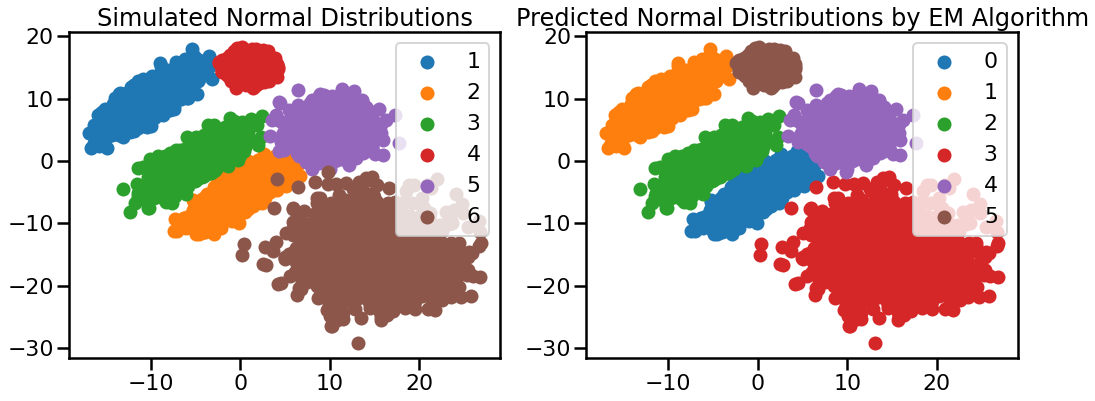

In [7]:
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal

GMM = my_GMM(k=6, initialization = "random")
GMM.fit(Y)
gmm_labels = GMM.labels_

fig, ax = plt.subplots(1,2, figsize=(17,6))

ax[0].scatter(X_1[:,0], X_1[:,1], label = 1)
ax[0].scatter(X_2[:,0], X_2[:,1], label = 2)
ax[0].scatter(X_3[:,0], X_3[:,1], label = 3)
ax[0].scatter(X_4[:,0], X_4[:,1], label = 4)
ax[0].scatter(X_5[:,0], X_5[:,1], label = 5)
ax[0].scatter(X_6[:,0], X_6[:,1], label = 6)
ax[0].legend()
ax[0].title.set_text('Simulated Normal Distributions')

for g in np.unique(gmm_labels):
    ix = np.where(gmm_labels== g)
    ax[1].scatter(x[ix], y[ix], label=g)
    ax[1].legend()
ax[1].title.set_text('Predicted Normal Distributions by EM Algorithm')


# Second Part
 
- Select the number of clusters using the model order selection methods from the lecture (AIC, BIC)

## AIC and BIC

### Implementation of the AIC and BIC Criteria

In [5]:
def loglikelihood(mu, sigma, alpha, X):
    n, p = X.shape
    k, p = mu.shape
    log_likelihood = np.zeros((k,n))
    for i in range(k):
        log_likelihood[i] = alpha[i]*multivariate_normal.pdf(X, mu[i], sigma[:,:,i])
    log_likelihood = np.sum(log_likelihood, axis = 0)
    log_likelihood = np.log(log_likelihood)
    log_likelihood = np.sum(log_likelihood, axis = 0)
    return log_likelihood

def nb_params_AIC(k, X):
    #nb of parameters for mu: k*p
    #nb of parameters for Sigma: p*p*k
    #nb of parameters for alpha: k
    n, p = X.shape
    return k*p + p*p*k + k

def nb_params_BIC(k, X):
    n, p = X.shape
    return 0.5*(k*p + p*p*k + k)*np.log(n)

def AIC_criterion(mu, sigma, alpha, X):
    k, p = mu.shape
    return nb_params_AIC(k, X) - loglikelihood(mu, sigma, alpha, X)

def BIC_criterion(mu, sigma, alpha, X):
    k, p = mu.shape
    return nb_params_BIC(k, X) - loglikelihood(mu, sigma, alpha, X)    

### Testing using AIC Criterion

#### Kmeans Initialization

The number of iterations of the EM algorithm for 1 clusters is: 1
The value of the AIC for 1 clusters is AIC = 86350.26533066679
The number of iterations of the EM algorithm for 2 clusters is: 10
The value of the AIC for 2 clusters is AIC = 84222.06322607075
The number of iterations of the EM algorithm for 3 clusters is: 8
The value of the AIC for 3 clusters is AIC = 78863.76533100575
The number of iterations of the EM algorithm for 4 clusters is: 10
The value of the AIC for 4 clusters is AIC = 76068.08049363639
The number of iterations of the EM algorithm for 5 clusters is: 8
The value of the AIC for 5 clusters is AIC = 72822.34879796498
The number of iterations of the EM algorithm for 6 clusters is: 7
The value of the AIC for 6 clusters is AIC = 70481.5293875755
The number of iterations of the EM algorithm for 7 clusters is: 391
The value of the AIC for 7 clusters is AIC = 70485.97711884006
The number of iterations of the EM algorithm for 8 clusters is: 501
The value of the AIC for 8

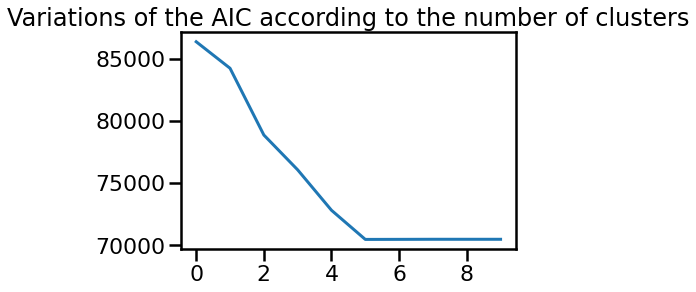

The best value of the AIC is: 70481.5293875755which corresponds to 6 clusters


In [28]:
AIC_crit = []

k_values = [i for i in range(1,11)]
for l in k_values:
    GMM = my_GMM(k=l, initialization = "kmeans")
    GMM.fit(Y)
    mu = GMM.mu_
    Sigma = GMM.Sigma_
    alpha = GMM.alpha_
    AIC = AIC_criterion(mu, Sigma, alpha, Y)
    print('The value of the AIC for ' + str(l)+ ' clusters is AIC = '+ str(AIC))
    AIC_crit.append(AIC)
    
plt.plot(AIC_crit)
plt.title('Variations of the AIC according to the number of clusters')
plt.show()
AIC_best = min(AIC_crit)
print('The best value of the AIC is: ' + str(AIC_best) + 'which corresponds to ' + str(AIC_crit.index(AIC_best)+1) + ' clusters')

#### Random Initialization

The number of iterations of the EM algorithm for 1 clusters is: 2
The value of the AIC for 1 clusters is AIC = 86350.26533066679
The number of iterations of the EM algorithm for 2 clusters is: 37
The value of the AIC for 2 clusters is AIC = 82034.81260744299
The number of iterations of the EM algorithm for 3 clusters is: 25
The value of the AIC for 3 clusters is AIC = 78985.72149064144
The number of iterations of the EM algorithm for 4 clusters is: 35
The value of the AIC for 4 clusters is AIC = 75806.91305354115
The number of iterations of the EM algorithm for 5 clusters is: 62
The value of the AIC for 5 clusters is AIC = 72547.9320067954
The number of iterations of the EM algorithm for 6 clusters is: 52
The value of the AIC for 6 clusters is AIC = 70481.52938757351
The number of iterations of the EM algorithm for 7 clusters is: 3096
The value of the AIC for 7 clusters is AIC = 70485.51430226446
The number of iterations of the EM algorithm for 8 clusters is: 2221
The value of the AIC 

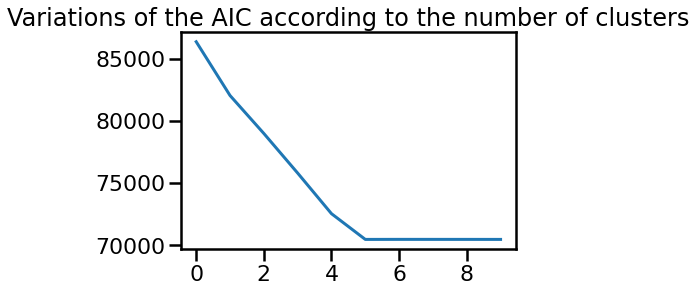

The best value of the AIC is: 70481.52938757351which corresponds to 6 clusters


In [27]:
AIC_crit = []

k_values = [i for i in range(1,11)]
for l in k_values:
    GMM = my_GMM(k=l, initialization = "random")
    GMM.fit(Y)
    mu = GMM.mu_
    Sigma = GMM.Sigma_
    alpha = GMM.alpha_
    AIC = AIC_criterion(mu, Sigma, alpha, Y)
    print('The value of the AIC for ' + str(l)+ ' clusters is AIC = '+ str(AIC))
    AIC_crit.append(AIC)
    
plt.plot(AIC_crit)
plt.title('Variations of the AIC according to the number of clusters')
plt.show()
AIC_best = min(AIC_crit)
print('The best value of the AIC is: ' + str(AIC_best) + 'which corresponds to ' + str(AIC_crit.index(AIC_best)+1) + ' clusters')

### Testing using BIC criterion

#### Kmeans Initialization

The number of iterations of the EM algorithm for 1 clusters is: 1
The value of the BIC for 1 clusters is BIC = 86376.13964741748
The number of iterations of the EM algorithm for 2 clusters is: 10
The value of the BIC for 2 clusters is BIC = 84273.81185957202
The number of iterations of the EM algorithm for 3 clusters is: 8
The value of the BIC for 3 clusters is BIC = 78941.38828125784
The number of iterations of the EM algorithm for 4 clusters is: 10
The value of the BIC for 4 clusters is BIC = 76171.57776063916
The number of iterations of the EM algorithm for 5 clusters is: 8
The value of the BIC for 5 clusters is BIC = 72951.72038171845
The number of iterations of the EM algorithm for 6 clusters is: 7
The value of the BIC for 6 clusters is BIC = 70636.77528807968
The number of iterations of the EM algorithm for 7 clusters is: 362
The value of the BIC for 7 clusters is BIC = 70667.0919664293
The number of iterations of the EM algorithm for 8 clusters is: 2592
The value of the BIC for 

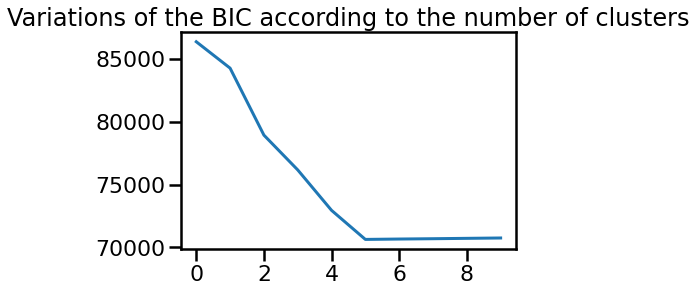

The best value of the BIC is: 70636.77528807968which corresponds to 6 clusters


In [31]:
BIC_crit = []

k_values = [i for i in range(1,11)]
for l in k_values:
    GMM = my_GMM(k=l, initialization = "kmeans")
    GMM.fit(Y)
    mu = GMM.mu_
    Sigma = GMM.Sigma_
    alpha = GMM.alpha_
    BIC = BIC_criterion(mu, Sigma, alpha, Y)
    print('The value of the BIC for ' + str(l)+ ' clusters is BIC = '+ str(BIC))
    BIC_crit.append(BIC)
    
plt.plot(BIC_crit)
plt.title('Variations of the BIC according to the number of clusters')
plt.show()
BIC_best = min(BIC_crit)
print('The best value of the BIC is: ' + str(BIC_best) + 'which corresponds to ' + str(BIC_crit.index(BIC_best)+1) + ' clusters')

#### Random Initialization

The number of iterations of the EM algorithm for 1 clusters is: 2
The value of the BIC for 1 clusters is BIC = 86376.13964741748
The number of iterations of the EM algorithm for 2 clusters is: 31
The value of the BIC for 2 clusters is BIC = 83362.47964174033
The number of iterations of the EM algorithm for 3 clusters is: 36
The value of the BIC for 3 clusters is BIC = 79917.95221506519
The number of iterations of the EM algorithm for 4 clusters is: 35
The value of the BIC for 4 clusters is BIC = 78331.24453937683
The number of iterations of the EM algorithm for 5 clusters is: 27
The value of the BIC for 5 clusters is BIC = 72951.72038171784
The number of iterations of the EM algorithm for 6 clusters is: 81
The value of the BIC for 6 clusters is BIC = 70636.77528807752
The number of iterations of the EM algorithm for 7 clusters is: 119
The value of the BIC for 7 clusters is BIC = 70660.84178654388
The number of iterations of the EM algorithm for 8 clusters is: 2688
The value of the BIC 

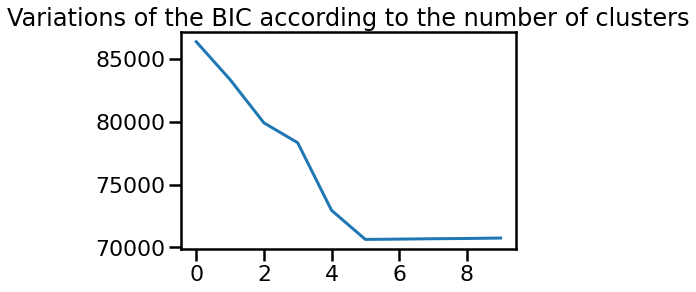

The best value of the BIC is: 70636.77528807752which corresponds to 6 clusters


In [36]:
BIC_crit = []

k_values = [i for i in range(1,11)]
for l in k_values:
    GMM = my_GMM(k=l, initialization = "random")
    GMM.fit(Y)
    mu = GMM.mu_
    Sigma = GMM.Sigma_
    alpha = GMM.alpha_
    BIC = BIC_criterion(mu, Sigma, alpha, Y)
    print('The value of the BIC for ' + str(l)+ ' clusters is BIC = '+ str(BIC))
    BIC_crit.append(BIC)
    
plt.plot(BIC_crit)
plt.title('Variations of the BIC according to the number of clusters')
plt.show()
BIC_best = min(BIC_crit)
print('The best value of the BIC is: ' + str(BIC_best) + 'which corresponds to ' + str(BIC_crit.index(BIC_best)+1) + ' clusters')

- Select the number of clusters using the model order reduction methods from the lecture (distance, correlation and parameter criteria)

## Order Reduction Methods

In [153]:
from sklearn.metrics import pairwise_distances
import math

def model_order_reduction(X, K, eps, criterion = "correlation"):
        gmm = my_GMM(k=K, initialization = 'kmeans')    
        gmm.fit(X)
        mu = gmm.mu_
        n, p = X.shape
        cond_matrix = gmm.cond_prob_
        num_clusters = K
        old_cluster = num_clusters + 1
        breaking = True
        if criterion == 'correlation':
            while old_cluster != num_clusters:
                breaking = False
                n_prob, p_prob = cond_matrix.shape
                old_cluster = num_clusters
                for i in range(p_prob-1):
                    for j in range(i+1,p_prob):
                        arr1 = cond_matrix[:,i]
                        arr2 = cond_matrix[:,j]
                        print(pearsonr(arr1, arr2))
                        if abs(pearsonr(arr1, arr2)[0]) > 1-eps: 
                            num_clusters -= 1
                            gmm = my_GMM(k=num_clusters, initialization = 'kmeans')    
                            gmm.fit(X)
                            cond_matrix = gmm.cond_prob_
                            breaking = True
                            break
                    if breaking:
                        break
        elif criterion == 'distance':
            while old_cluster != num_clusters:
                distance = pairwise_distances(mu)
                for i in range(distance.shape[0]):
                    distance[i,i] = math.inf
                min_distance = np.amin(distance)
                print(min_distance)
                if min_distance < eps:
                    num_clusters -= 1
                    gmm = my_GMM(k=num_clusters, initialization = 'kmeans')    
                    gmm.fit(X)
                    mu = gmm.mu_
        return 'Tre number of clusters is: ' + str(num_clusters)

In [147]:
print(model_order_reduction(Y,8,5, criterion = "distance"))

The number of iterations of the EM algorithm for 8 clusters is: 8614
1.5428669920930311
The number of iterations of the EM algorithm for 7 clusters is: 3586
1.3586614404698925
The number of iterations of the EM algorithm for 6 clusters is: 8
7.004399454723193
Tre number of clusters is: 6


In [154]:
print(model_order_reduction(Y,8,0.3, criterion = "correlation"))

The number of iterations of the EM algorithm for 8 clusters is: 9114
(-0.1975199369499134, 7.676901117385557e-106)
(-0.2001783137160969, 1.0269776430048425e-108)
(-0.2000682394950008, 1.3532259768747032e-108)
(-0.20005045158060072, 1.4148967616831264e-108)
(-0.20014610570800362, 1.1133324795708562e-108)
(-0.18034611435433576, 2.8762081795185165e-88)
(-0.026805018760469715, 0.0033186990102275736)
(-0.1972444062825277, 1.5158591570404372e-105)
(-0.19745107884099405, 9.100588306278937e-106)
(-0.19754881876512712, 7.148057143101624e-106)
(-0.1975278847858642, 7.527595512406358e-106)
(0.8256172819832575, 0.0)
The number of iterations of the EM algorithm for 7 clusters is: 3804
(-0.2005627619048138, 3.9133937753987706e-109)
(-0.20018975665883457, 9.979342664914786e-109)
(-0.1844183038859614, 2.792946944649164e-92)
(-0.19969542579077681, 3.440550028964048e-108)
(-0.2000683103553244, 1.3529857471240516e-108)
(-0.19735864681890447, 1.1434146796874322e-105)
(-0.1975540403715722, 7.05640194556644

Do these two methods (order selection and reduction) agree on the final number of clusters for the two given datasets (data-MM-i.csv)? Does it make sense?

Compare the results and the computational time. Try to visually validate your results.

Comment. 

## Testing on the Given Datasets

### Data_MM_1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   C1      1000 non-null   float64
 1   C2      1000 non-null   float64
 2   C3      1000 non-null   float64
dtypes: float64(3)
memory usage: 23.6 KB
None


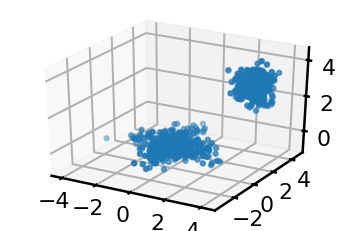

In [108]:
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
data_MM_1 = pd.read_csv('data_MM_1.csv', names = ['C1', 'C2', 'C3'])
print(data_MM_1.info())
threedee = plt.figure().gca(projection='3d')
threedee.scatter(data_MM_1['C1'], data_MM_1['C2'], data_MM_1['C3'])
plt.show()

In [109]:
X_model_1 = data_MM_1[["C1", "C2", "C3"]].to_numpy() 
print(X_model_1)
n, p = X_model_1.shape

[[-0.25233983 -0.65697213 -0.26435481]
 [ 2.48215483  2.62576715  3.18681239]
 [ 3.2899495   3.12791594  4.32237293]
 ...
 [ 2.94410401  2.78115907  2.48151659]
 [ 3.18502503  2.80503261  3.94432179]
 [-0.283677    1.29097357 -0.51458309]]


#### AIC Criterion Tests

The number of iterations of the EM algorithm for 1 clusters is: 1
The value of the AIC for 1 clusters is AIC = 4107.954897310745
The number of iterations of the EM algorithm for 2 clusters is: 1
The value of the AIC for 2 clusters is AIC = 2994.702448656834
The number of iterations of the EM algorithm for 3 clusters is: 47
The value of the AIC for 3 clusters is AIC = 2842.70855903927
The number of iterations of the EM algorithm for 4 clusters is: 444
The value of the AIC for 4 clusters is AIC = 2845.885367199397
The number of iterations of the EM algorithm for 5 clusters is: 357
The value of the AIC for 5 clusters is AIC = 2851.754448200527
The number of iterations of the EM algorithm for 6 clusters is: 1026
The value of the AIC for 6 clusters is AIC = 2849.411086091583
The number of iterations of the EM algorithm for 7 clusters is: 1204
The value of the AIC for 7 clusters is AIC = 2853.321781078332
The number of iterations of the EM algorithm for 8 clusters is: 495
The value of the AI

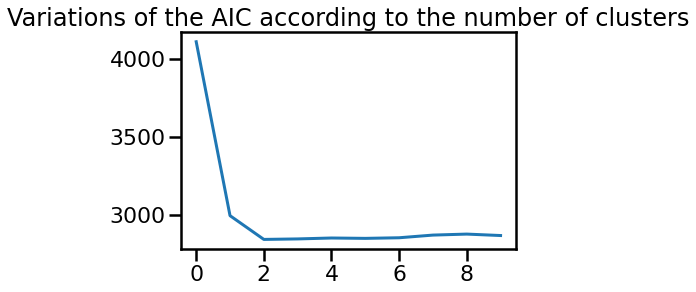

The best value of the AIC is: 2842.70855903927which corresponds to 3 clusters


In [195]:
AIC_crit = []

k_values = [i for i in range(1,11)]
for l in k_values:
    GMM = my_GMM(k=l, initialization = "kmeans")
    GMM.fit(X_model_1)
    mu = GMM.mu_
    Sigma = GMM.Sigma_
    alpha = GMM.alpha_
    AIC = AIC_criterion(mu, Sigma, alpha, X_model_1)
    print('The value of the AIC for ' + str(l)+ ' clusters is AIC = '+ str(AIC))
    AIC_crit.append(AIC)
    
plt.plot(AIC_crit)
plt.title('Variations of the AIC according to the number of clusters')
plt.show()
AIC_best = min(AIC_crit)
print('The best value of the AIC is: ' + str(AIC_best) + 'which corresponds to ' + str(AIC_crit.index(AIC_best)+1) + ' clusters')

#### BIC Criterion Tests

The number of iterations of the EM algorithm for 1 clusters is: 1
The value of the AIC for 1 clusters is AIC = 4139.855306624129
The number of iterations of the EM algorithm for 2 clusters is: 1
The value of the AIC for 2 clusters is AIC = 3058.503267283602
The number of iterations of the EM algorithm for 3 clusters is: 47
The value of the AIC for 3 clusters is AIC = 2938.409786952383
The number of iterations of the EM algorithm for 4 clusters is: 651
The value of the AIC for 4 clusters is AIC = 2971.274418353991
The number of iterations of the EM algorithm for 5 clusters is: 363
The value of the AIC for 5 clusters is AIC = 3011.2564936013796
The number of iterations of the EM algorithm for 6 clusters is: 419
The value of the AIC for 6 clusters is AIC = 3052.731463663027
The number of iterations of the EM algorithm for 7 clusters is: 1128
The value of the AIC for 7 clusters is AIC = 3088.5425670668883
The number of iterations of the EM algorithm for 8 clusters is: 1206
The value of the

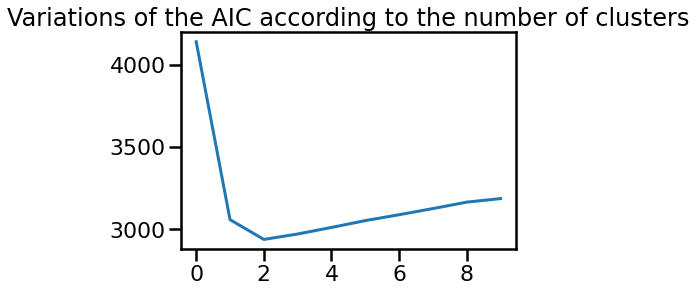

The best value of the AIC is: 2938.409786952383which corresponds to 3 clusters


In [39]:
BIC_crit = []

k_values = [i for i in range(1,11)]
for l in k_values:
    GMM = my_GMM(k=l, initialization = "kmeans")
    GMM.fit(X_model_1)
    mu = GMM.mu_
    Sigma = GMM.Sigma_
    alpha = GMM.alpha_
    BIC = BIC_criterion(mu, Sigma, alpha, X_model_1)
    print('The value of the AIC for ' + str(l)+ ' clusters is AIC = '+ str(BIC))
    BIC_crit.append(BIC)
    
plt.plot(BIC_crit)
plt.title('Variations of the AIC according to the number of clusters')
plt.show()
BIC_best = min(BIC_crit)
print('The best value of the AIC is: ' + str(BIC_best) + 'which corresponds to ' + str(BIC_crit.index(BIC_best)+1) + ' clusters')

In [123]:
print(model_order_reduction(X_model_1,15,0.5, criterion = "correlation"))

The number of iterations of the EM algorithm for 15 clusters is: 1672
(-0.024972885891601723, 0.4302012566152708)
(-0.020762872905318704, 0.5119340322685465)
(-0.021570800146676783, 0.4956470676120798)
(-0.09202262011084544, 0.0035848740657816614)
(-0.045998847661019006, 0.14606794304368856)
(-0.01907343363102329, 0.5468710717247177)
(-0.05203622549351431, 0.10005519508061564)
(-0.08853656090205433, 0.005082249362261368)
(0.08484177377748413, 0.0072656172679125405)
(0.0048551762911828306, 0.8781277682362498)
(-0.03054494525639596, 0.3345783515844325)
(-0.026028846033708027, 0.4109549912919789)
(-0.017254046941697916, 0.5857679467085357)
(-0.03091998616550441, 0.3286748908259579)
(-0.02786638812839589, 0.3787069066587958)
(-0.030333110456542106, 0.3379427798923396)
(-0.005577896110376324, 0.8601609225722141)
(-0.06550466611807482, 0.03835194862828514)
(-0.01845692977957944, 0.5599074161392467)
(-0.07414173801588345, 0.019034067012060788)
(-0.054675890621385684, 0.08396424684621917)
(-0.

### Data_MM_2

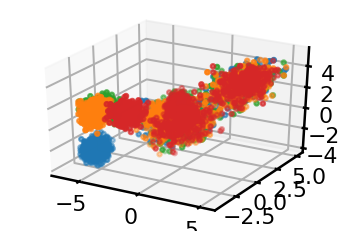

In [26]:
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
data_MM_2 = pd.read_csv('data_MM_2.csv', names = ['C1', 'C2', 'C3', 'C4'])
threedee = plt.figure().gca(projection='3d')
threedee.scatter(data_MM_2['C1'], data_MM_2['C2'], data_MM_2['C3'])
threedee.scatter(data_MM_2['C1'], data_MM_2['C2'], data_MM_2['C4'])
threedee.scatter(data_MM_2['C1'], data_MM_2['C3'], data_MM_2['C4'])
threedee.scatter(data_MM_2['C2'], data_MM_2['C3'], data_MM_2['C4'])
plt.show()

In [118]:
X_model_2 = data_MM_2[["C1", "C2", "C3", "C4"]].to_numpy() 
print(X_model_2)
n, p = X_model_2.shape

[[-5.54756729 -2.84666605 -2.42803785  1.15333554]
 [ 2.9064721   2.82478726  2.53865624  2.94265361]
 [-5.31567352 -2.82217776 -2.31536358  2.20563892]
 ...
 [-1.48460186 -0.92517901 -1.15264264 -0.0229337 ]
 [ 1.06096371  0.17658467  0.49517688 -0.43894492]
 [-5.23771429 -3.40283589 -1.57559156  1.62539381]]


#### AIC Criterion Tests

The number of iterations of the EM algorithm for 1 clusters is: 1
The value of the AIC for 1 clusters is AIC = 9511.168140077945
The number of iterations of the EM algorithm for 2 clusters is: 6
The value of the AIC for 2 clusters is AIC = 7834.861345015219
The number of iterations of the EM algorithm for 3 clusters is: 11
The value of the AIC for 3 clusters is AIC = 7355.3775030241395
The number of iterations of the EM algorithm for 4 clusters is: 26
The value of the AIC for 4 clusters is AIC = 7122.027667408527
The number of iterations of the EM algorithm for 5 clusters is: 416
The value of the AIC for 5 clusters is AIC = 7133.699937833499
The number of iterations of the EM algorithm for 6 clusters is: 378
The value of the AIC for 6 clusters is AIC = 7140.850323519544
The number of iterations of the EM algorithm for 7 clusters is: 379
The value of the AIC for 7 clusters is AIC = 7150.128864648818
The number of iterations of the EM algorithm for 8 clusters is: 518
The value of the AIC

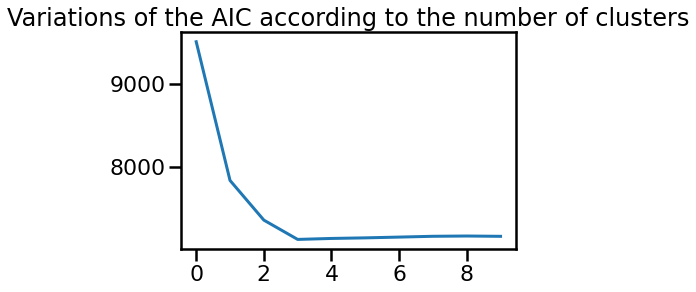

The best value of the AIC is: 7122.027667408527which corresponds to 4 clusters


In [40]:
AIC_crit = []

k_values = [i for i in range(1,11)]
for l in k_values:
    GMM = my_GMM(k=l, initialization = "kmeans")
    GMM.fit(X_model_2)
    mu = GMM.mu_
    Sigma = GMM.Sigma_
    alpha = GMM.alpha_
    AIC = AIC_criterion(mu, Sigma, alpha, X_model_2)
    print('The value of the AIC for ' + str(l)+ ' clusters is AIC = '+ str(AIC))
    AIC_crit.append(AIC)
    
plt.plot(AIC_crit)
plt.title('Variations of the AIC according to the number of clusters')
plt.show()
AIC_best = min(AIC_crit)
print('The best value of the AIC is: ' + str(AIC_best) + 'which corresponds to ' + str(AIC_crit.index(AIC_best)+1) + ' clusters')

#### BIC Criterion Tests

The number of iterations of the EM algorithm for 1 clusters is: 1
The value of the BIC for 1 clusters is BIC = 9566.956954142393
The number of iterations of the EM algorithm for 2 clusters is: 6
The value of the BIC for 2 clusters is BIC = 7946.438973144115
The number of iterations of the EM algorithm for 3 clusters is: 11
The value of the BIC for 3 clusters is BIC = 7522.743945217482
The number of iterations of the EM algorithm for 4 clusters is: 26
The value of the BIC for 4 clusters is BIC = 7345.18292366632
The number of iterations of the EM algorithm for 5 clusters is: 416
The value of the BIC for 5 clusters is BIC = 7412.64400816725
The number of iterations of the EM algorithm for 6 clusters is: 379
The value of the BIC for 6 clusters is BIC = 7475.583207778472
The number of iterations of the EM algorithm for 7 clusters is: 378
The value of the BIC for 7 clusters is BIC = 7540.65055193612
The number of iterations of the EM algorithm for 8 clusters is: 520
The value of the BIC for

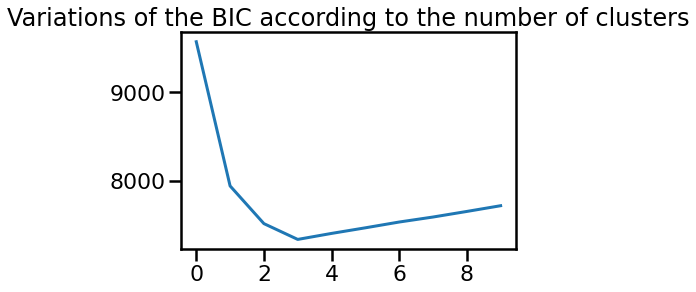

The best value of the BIC is: 7345.18292366632which corresponds to 4 clusters


In [42]:
BIC_crit = []

k_values = [i for i in range(1,11)]
for l in k_values:
    GMM = my_GMM(k=l, initialization = "kmeans")
    GMM.fit(X_model_2)
    mu = GMM.mu_
    Sigma = GMM.Sigma_
    alpha = GMM.alpha_
    BIC = BIC_criterion(mu, Sigma, alpha, X_model_2)
    print('The value of the BIC for ' + str(l)+ ' clusters is BIC = '+ str(BIC))
    BIC_crit.append(BIC)
    
plt.plot(BIC_crit)
plt.title('Variations of the BIC according to the number of clusters')
plt.show()
BIC_best = min(BIC_crit)
print('The best value of the BIC is: ' + str(BIC_best) + 'which corresponds to ' + str(BIC_crit.index(BIC_best)+1) + ' clusters')

In [129]:
print(model_order_reduction(X_model_2,8,0.705, criterion = "correlation"))

The number of iterations of the EM algorithm for 8 clusters is: 518
(-0.22862537991747478, 3.067774227798615e-19)
(-0.22889308676427542, 2.781544171228452e-19)
(-0.1489385693585453, 6.7951020957078815e-09)
(-0.2117995867758073, 1.1291526943983444e-16)
(-0.277139059265543, 7.454479652095377e-28)
(0.10235971372296172, 7.141994872966898e-05)
(-0.20584187468217657, 8.148454517037903e-16)
(-0.16593267454259164, 1.0059034627711801e-10)
(0.187229624509877, 2.6701980193801187e-13)
(-0.14876498601542396, 7.077276950326241e-09)
(-0.15941869383629192, 5.337053577962674e-10)
(-0.24559868801922813, 4.807715872631432e-22)
(0.11198720011700038, 1.37816827508023e-05)
(-0.10810348060964747, 2.7210201675031058e-05)
(0.188982954676228, 1.5856147077177068e-13)
(-0.20115462966642922, 3.699454576081877e-15)
(-0.2458862681372235, 4.290519494224541e-22)
(-0.14931914837970778, 6.214164235019994e-09)
(-0.10003013495927192, 0.0001041745485108597)
(-0.11939943717460738, 3.5339615631536585e-06)
(-0.159995943837697

## Application

You are going to work with the following data:

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
shape: (1797, 64)


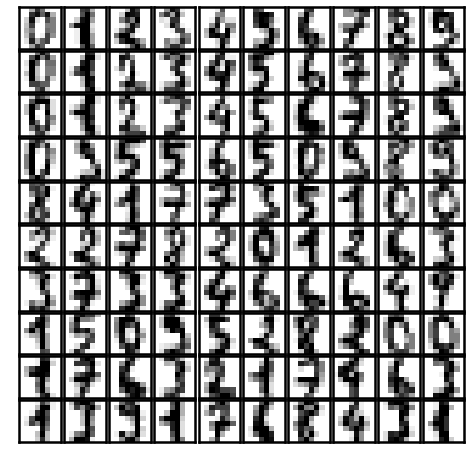

In [5]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data)
print("shape:", digits.data.shape)

def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

Model your data with your GMM class using a model order selection method to produce new synthetic handwritten numbers. Explain why you used that model selection method in this case. Finally, sample from every class and visualize to get an idea of what each cluster corresponds to. You should use PCA to reduce the dimension as GMM doesn't perform well in high-dimensional contexts. 

In [27]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

data = digits.data
n,p = data.shape
number_digits = 10
labels = digits.target

dim_red = 15
pca = PCA(n_components = dim_red)
data_reduced = pca.fit_transform(data)

In [34]:
model = my_GMM(k=10, initialization = 'kmeans')
data_bis = model.fit(data_reduced)
pred_labels = model.predict(data_reduced)

The number of iterations of the EM algorithm for 10 clusters is: 99
[3 2 2 ... 6 1 6]


To test the model we have to rearrange the labels. To do so we took one of our colleague's code just to do the rearranging.